## Notebook for kaggle competition : COVID19 Global Forecasting (Week 4)
### Forecast daily COVID-19 spread in regions around world

### DSANet approach

Important notes:

- this approach offers multivariate time series forecasting
- I use only data about COVID-19 cases and fatalities without additional resources
- I forecast the number of new confirmed cases and deaths (in the final I calculate each cumulative sum for the final result)
- I use only data from the end of February because I don't believe in truthfully of Chinese data

Solution based on these implementations [1](https://github.com/bighuang624/DSANet) & [2](https://www.kaggle.com/kirichenko17roman/old-dsanet-approach) of [Dual Self-Attention Network for Multivariate Time Series Forecasting](https://dl.acm.org/doi/10.1145/3357384.3358132)

NN architecture:

![](https://raw.githubusercontent.com/bighuang624/DSANet/master/docs/DSANet-model-structure.png)

Additional information about the contries is added before the dense layer.

Define week number:

In [1]:
week = 4

Load libraries:

In [2]:
import numpy as np 
import pandas as pd
import datetime
import os
import matplotlib.pyplot as plt

from models import *

pd.set_option('display.max_columns', 500)


In [3]:
train = pd.read_csv(f"/kaggle/input/covid19-global-forecasting-week-{week}/train.csv")
train["geo"] = np.where(train["Province_State"].isna(), train["Country_Region"], train["Country_Region"] + "_" + train["Province_State"])

train['Date'] = pd.to_datetime(train['Date'])
train = train.loc[train['Date'] > '2020-02-20', :]
train_last_date = train.Date.unique()[-1]
print(f"Dataset has training data untill : {str(train_last_date)[:10]}")
print(f"Training dates: {len(train.Date.unique())}")

Dataset has training data untill : 2020-04-11
Training dates: 51


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15963 entries, 30 to 25352
Data columns (total 7 columns):
Id                15963 non-null int64
Province_State    6783 non-null object
Country_Region    15963 non-null object
Date              15963 non-null datetime64[ns]
ConfirmedCases    15963 non-null float64
Fatalities        15963 non-null float64
geo               15963 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 997.7+ KB


In [5]:
train.describe(include='all')

Id Province_State Country_Region                 Date  \
count   15963.00000           6783          15963                15963   
unique          NaN            133            184                   51   
top             NaN      Chongqing             US  2020-04-09 00:00:00   
freq            NaN             51           2754                  313   
first           NaN            NaN            NaN  2020-02-21 00:00:00   
last            NaN            NaN            NaN  2020-04-11 00:00:00   
mean    17840.00000            NaN            NaN                  NaN   
std     10300.78675            NaN            NaN                  NaN   
min        31.00000            NaN            NaN                  NaN   
25%      8935.50000            NaN            NaN                  NaN   
50%     17840.00000            NaN            NaN                  NaN   
75%     26744.50000            NaN            NaN                  NaN   
max     35649.00000            NaN            NaN                  NaN   

        ConfirmedCases    Fatalities       geo  
count     15963.000000  15963.000000     15963  
unique             NaN           NaN       313  
top                NaN           NaN  Maldives  
freq               NaN           NaN        51  
first              NaN           NaN       NaN  
last               NaN           NaN       NaN  
mean       1532.825221     78.540061       NaN  
std        9352.360471    744.392361       NaN  
min           0.000000      0.000000       NaN  
25%           0.000000      0.000000       NaN  
50%          16.000000      0.000000       NaN  
75%         264.000000      3.000000       NaN  
max      181026.000000  19468.000000       NaN

In [6]:
additional = pd.read_csv(f"../input/covid19-country-data-wk3-release/Data Join - RELEASE.csv")
additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 30 columns):
Province_State               130 non-null object
Country_Region               306 non-null object
GDP_region                   306 non-null float64
TRUE POPULATION              306 non-null object
pct_in_largest_city          306 non-null object
 TFR                         303 non-null object
 Avg_age                     306 non-null object
latitude                     306 non-null float64
longitude                    306 non-null float64
abs_latitude                 306 non-null float64
temperature                  294 non-null float64
humidity                     294 non-null float64
Personality_pdi              230 non-null object
Personality_idv              230 non-null object
Personality_mas              230 non-null object
Personality_uai              230 non-null object
Personality_ltowvs           230 non-null object
Personality_assertive        306 non-null float64
person

In [7]:
additional["TRUE POPULATION"] = additional["TRUE POPULATION"].str.strip().str.replace(',','').astype(int)
additional['pct_in_largest_city'] = additional['pct_in_largest_city'].str.replace('%','').astype(float)
additional[' TFR '] = additional[' TFR '].replace('N.A.',np.nan).astype(float)
additional['Personality_uai'] = pd.to_numeric(additional['Personality_uai'], errors='coerce')
additional['Personality_pdi'] = pd.to_numeric(additional['Personality_pdi'], errors='coerce')
additional['Personality_idv'] = pd.to_numeric(additional['Personality_idv'], errors='coerce')
additional['Personality_ltowvs'] = pd.to_numeric(additional['Personality_ltowvs'], errors='coerce')
additional['personality_agreeableness'] = pd.to_numeric(additional['personality_agreeableness'], errors='coerce')
additional['AIR_AVG'] = pd.to_numeric(additional['AIR_AVG'], errors='coerce')
additional[' Avg_age '] = pd.to_numeric(additional[' Avg_age '], errors='coerce')
additional['Personality_mas'] = pd.to_numeric(additional['Personality_mas'], errors='coerce')


In [8]:
additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 30 columns):
Province_State               130 non-null object
Country_Region               306 non-null object
GDP_region                   306 non-null float64
TRUE POPULATION              306 non-null int64
pct_in_largest_city          306 non-null float64
 TFR                         297 non-null float64
 Avg_age                     305 non-null float64
latitude                     306 non-null float64
longitude                    306 non-null float64
abs_latitude                 306 non-null float64
temperature                  294 non-null float64
humidity                     294 non-null float64
Personality_pdi              207 non-null float64
Personality_idv              207 non-null float64
Personality_mas              207 non-null float64
Personality_uai              207 non-null float64
Personality_ltowvs           222 non-null float64
Personality_assertive        306 non-null float64

In [9]:

additional["geo"] = np.where(additional["Province_State"].isna(), additional["Country_Region"], additional["Country_Region"] + "_" + additional["Province_State"])
additional.describe(include ='all')

Province_State Country_Region  GDP_region  TRUE POPULATION  \
count             130            306  306.000000     3.060000e+02   
unique            130            180         NaN              NaN   
top         Chongqing             US         NaN              NaN   
freq                1             54         NaN              NaN   
mean              NaN            NaN    4.094444     2.459289e+07   
std               NaN            NaN    1.953174     8.574671e+07   
min               NaN            NaN    0.000000     8.010000e+02   
25%               NaN            NaN    2.500000     1.297000e+06   
50%               NaN            NaN    4.100000     6.022840e+06   
75%               NaN            NaN    5.775000     2.192750e+07   
max               NaN            NaN    8.500000     1.380004e+09   

        pct_in_largest_city        TFR     Avg_age     latitude   longitude  \
count            306.000000  297.000000  305.000000  306.000000  306.000000   
unique                  NaN         NaN         NaN         NaN         NaN   
top                     NaN         NaN         NaN         NaN         NaN   
freq                    NaN         NaN         NaN         NaN         NaN   
mean              15.865065    2.247273   34.221639   25.025490    4.487680   
std               13.805945    1.054209    8.110908   23.339031   79.105102   
min                0.453000    1.100000   15.000000  -41.450000 -157.500000   
25%                7.408000    1.700000   29.000000   12.605000  -70.790000   
50%               14.591000    1.800000   38.000000   31.000000   10.470000   
75%               20.000000    2.300000   39.000000   42.000000   55.430000   
max              109.632000    7.000000   58.000000   71.710000  178.070000   

        abs_latitude  temperature    humidity  Personality_pdi  \
count     306.000000   294.000000  294.000000       207.000000   
unique           NaN          NaN         NaN              NaN   
top              NaN          NaN         NaN              NaN   
freq             NaN          NaN         NaN              NaN   
mean       30.292810    16.646939   69.394218        52.154831   
std        15.886341    12.611890   17.270733        22.657317   
min         0.020000   -35.200000   10.600000         0.000000   
25%        17.015000     7.600000   64.425000        39.000000   
50%        32.315000    17.500000   75.400000        40.000000   
75%        42.000000    26.850000   80.000000        73.500000   
max        71.710000    40.800000   96.300000       104.000000   

        Personality_idv  Personality_mas  Personality_uai  Personality_ltowvs  \
count        207.000000       207.000000       207.000000          222.000000   
unique              NaN              NaN              NaN                 NaN   
top                 NaN              NaN              NaN                 NaN   
freq                NaN              NaN              NaN                 NaN   
mean          57.581449        53.005652        50.381643           45.380364   
std           32.304862        18.722969        23.685936           25.921568   
min            0.000000         0.000000         0.000000            0.000000   
25%           20.000000        43.000000        35.000000           26.000000   
50%           71.000000        62.000000        46.000000           36.000000   
75%           91.000000        66.000000        63.500000           63.750000   
max           91.000000       110.000000       112.000000          100.000000   

        Personality_assertive  personality_perform  personality_agreeableness  \
count              306.000000           199.000000                  184.00000   
unique                    NaN                  NaN                        NaN   
top                       NaN                  NaN                        NaN   
freq                      NaN                  NaN                        NaN   
mean                 3.587255             3.234322        

In [10]:
additional.describe()

GDP_region  TRUE POPULATION  pct_in_largest_city        TFR   \
count  306.000000     3.060000e+02           306.000000  297.000000   
mean     4.094444     2.459289e+07            15.865065    2.247273   
std      1.953174     8.574671e+07            13.805945    1.054209   
min      0.000000     8.010000e+02             0.453000    1.100000   
25%      2.500000     1.297000e+06             7.408000    1.700000   
50%      4.100000     6.022840e+06            14.591000    1.800000   
75%      5.775000     2.192750e+07            20.000000    2.300000   
max      8.500000     1.380004e+09           109.632000    7.000000   

         Avg_age     latitude   longitude  abs_latitude  temperature  \
count  305.000000  306.000000  306.000000    306.000000   294.000000   
mean    34.221639   25.025490    4.487680     30.292810    16.646939   
std      8.110908   23.339031   79.105102     15.886341    12.611890   
min     15.000000  -41.450000 -157.500000      0.020000   -35.200000   
25%     29.000000   12.605000  -70.790000     17.015000     7.600000   
50%     38.000000   31.000000   10.470000     32.315000    17.500000   
75%     39.000000   42.000000   55.430000     42.000000    26.850000   
max     58.000000   71.710000  178.070000     71.710000    40.800000   

         humidity  Personality_pdi  Personality_idv  Personality_mas  \
count  294.000000       207.000000       207.000000       207.000000   
mean    69.394218        52.154831        57.581449        53.005652   
std     17.270733        22.657317        32.304862        18.722969   
min     10.600000         0.000000         0.000000         0.000000   
25%     64.425000        39.000000        20.000000        43.000000   
50%     75.400000        40.000000        71.000000        62.000000   
75%     80.000000        73.500000        91.000000        66.000000   
max     96.300000       104.000000        91.000000       110.000000   

       Personality_uai  Personality_ltowvs  Personality_assertive  \
count       207.000000          222.000000             306.000000   
mean         50.381643           45.380364               3.587255   
std          23.685936           25.921568               0.646940   
min           0.000000            0.000000               3.000000   
25%          35.000000           26.000000               3.000000   
50%          46.000000           36.000000               3.000000   
75%          63.500000           63.750000               4.435000   
max         112.000000          100.000000               4.720000   

       personality_perform  personality_agreeableness      murder  \
count           199.000000                  184.00000  306.000000   
mean              3.234322                   47.49000    0.869281   
std               1.870120                    3.06096    1.179485   
min               0.000000                   39.05000   -1.600000   
25%               3.375000                   45.29750    0.000000   
50%               4.370000                   47.92500    0.600000   
75%               4.450000                   50.00000    1.800000   
max               5.040000                   60.00000    4.400000   

         High_rises  max_high_rises  AIR_CITIES     AIR_AVG  continent_gdp_pc  \
count    306.000000      306.000000  306.000000  192.000000        306.000000   
mean    4853.330065     1802.774510  186.915033   18.925521          9.843039   
std     7545.498113     2626.473264  276.087333   15.537178          0.978747   
min        0.000000        0.000000    0.000000    4.200000          7.900000   
25%        0.000000        0.000000    0.000000    8.500000          9.300000   
50%      698.000000      359.000000   15.000000   10.500000         10.320000   
75%     7895.000000     1970.250000  390.000000   29.950000         10.705000   
max    61479.000000    16759.000000  723.000000   97.100000         10.710000   

       continent_happiness  continent_generosity  continent_corruption  \
count           306.0

In [11]:
additional.drop(['Province_State','Country_Region'],inplace=True,axis=1)

In [12]:
additional.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 29 columns):
GDP_region                   306 non-null float64
TRUE POPULATION              306 non-null int64
pct_in_largest_city          306 non-null float64
 TFR                         297 non-null float64
 Avg_age                     305 non-null float64
latitude                     306 non-null float64
longitude                    306 non-null float64
abs_latitude                 306 non-null float64
temperature                  294 non-null float64
humidity                     294 non-null float64
Personality_pdi              207 non-null float64
Personality_idv              207 non-null float64
Personality_mas              207 non-null float64
Personality_uai              207 non-null float64
Personality_ltowvs           222 non-null float64
Personality_assertive        306 non-null float64
personality_perform          199 non-null float64
personality_agreeableness    184 non-null float

In [13]:
train_add = train.merge(additional,on='geo',how='left')

In [14]:
train_add.describe(include='all')

Id Province_State Country_Region                 Date  \
count   15963.00000           6783          15963                15963   
unique          NaN            133            184                   51   
top             NaN      Chongqing             US  2020-04-09 00:00:00   
freq            NaN             51           2754                  313   
first           NaN            NaN            NaN  2020-02-21 00:00:00   
last            NaN            NaN            NaN  2020-04-11 00:00:00   
mean    17840.00000            NaN            NaN                  NaN   
std     10300.78675            NaN            NaN                  NaN   
min        31.00000            NaN            NaN                  NaN   
25%      8935.50000            NaN            NaN                  NaN   
50%     17840.00000            NaN            NaN                  NaN   
75%     26744.50000            NaN            NaN                  NaN   
max     35649.00000            NaN            NaN                  NaN   

        ConfirmedCases    Fatalities       geo    GDP_region  TRUE POPULATION  \
count     15963.000000  15963.000000     15963  15606.000000     1.560600e+04   
unique             NaN           NaN       313           NaN              NaN   
top                NaN           NaN  Maldives           NaN              NaN   
freq               NaN           NaN        51           NaN              NaN   
first              NaN           NaN       NaN           NaN              NaN   
last               NaN           NaN       NaN           NaN              NaN   
mean       1532.825221     78.540061       NaN      4.094444     2.459289e+07   
std        9352.360471    744.392361       NaN      1.950042     8.560923e+07   
min           0.000000      0.000000       NaN      0.000000     8.010000e+02   
25%           0.000000      0.000000       NaN      2.500000     1.296000e+06   
50%          16.000000      0.000000       NaN      4.100000     6.022840e+06   
75%         264.000000      3.000000       NaN      5.800000     2.200000e+07   
max      181026.000000  19468.000000       NaN      8.500000     1.380004e+09   

        pct_in_largest_city          TFR       Avg_age       latitude  \
count          15606.000000  15147.000000  15555.000000  15606.000000   
unique                  NaN           NaN           NaN           NaN   
top                     NaN           NaN           NaN           NaN   
freq                    NaN           NaN           NaN           NaN   
first                   NaN           NaN           NaN           NaN   
last                    NaN           NaN           NaN           NaN   
mean              15.865065      2.247273     34.221639     25.025490   
std               13.783810      1.052467      8.097861     23.301611   
min                0.453000      1.100000     15.000000    -41.450000   
25%                7.396000      1.700000     29.000000     12.520000   
50%               14.591000      1.800000     38.000000     31.000000   
75%               20.000000      2.300000     39.000000     42.000000   
max              109.632000      7.000000     58.000000     71.710000   

          longitude  abs_latitude   temperature      humidity  \
count   15606.00000   15606.00000  14994.000000  14994.000000   
unique          NaN           NaN           NaN           NaN   
top             NaN           NaN           NaN           NaN   
freq            NaN           NaN           NaN           NaN   
first           NaN           NaN           NaN           NaN   
last            NaN           NaN           NaN           NaN   
mean        4.48768      30.29281     16.646939     69.394218   
std        78.97827      15.86087     12.590843     17.241911   
min      -157.50000       0.02000    -35.200000     10.600000   
25%       -71.00000      17.00000      7.600000     64.400000   
50%        10.47000      32.31500     17.500000     75.400000   
75%        55.49000      42.00000     26.9

In [16]:
add_cols = [c for c in train_add.columns if c not in train.columns]

In [17]:
#discreteCol = [i for i in range(len(X_train.columns)) if X_train_norm.columns[i] in ['year','month','day','dayYear']]
X_train = train_add[add_cols]
X_train.replace(np.nan,X_train.mean(),inplace=True)
Fs = selectFeaturesTransformer(method="Mutual Information", discreteCol=[],k=len(X_train.columns),order=[])
Fs.fit(X_train,train_add['ConfirmedCases'])
print("Top 10 selected by Mutual information for ConfirmedCases ")
print(list(X_train.columns[Fs.order]))

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4278: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


Top 10 selected by Mutual information for ConfirmedCases 
['latitude', 'longitude', 'abs_latitude', 'TRUE POPULATION', 'temperature', 'humidity', 'pct_in_largest_city', 'GDP_region', 'Personality_ltowvs', 'AIR_AVG', 'personality_agreeableness', 'Personality_pdi', 'Personality_uai', 'Personality_idv', 'AIR_CITIES', 'High_rises', 'murder', 'personality_perform', 'max_high_rises', 'Personality_assertive', ' TFR ', 'Personality_mas', 'continent_gdp_pc', 'continent_happiness', ' Avg_age ', 'continent_Life_expectancy', 'continent_generosity', 'continent_corruption']


In [18]:
print(list(Fs.scores))

[0.8924013035124005, 0.886072352562894, 0.8780406570396453, 0.8614148733140654, 0.7854464688384919, 0.7541040902414009, 0.6527620511201304, 0.6043130251873379, 0.37385810606087766, 0.3699945857122904, 0.34330640283142166, 0.3418971198046119, 0.3375577023792333, 0.3362241410088549, 0.330110192247707, 0.3297179246296089, 0.32734228711398927, 0.3272304043863876, 0.32367678812905076, 0.3122085722119703, 0.3032585368056484, 0.2965686382903998, 0.2743203200673534, 0.27110377124683094, 0.259574263771686, 0.25864114800231697, 0.2535211267671391, 0.23928005009139053]


In [21]:
Fs_rf = selectFeaturesTransformer(method="RF", discreteCol=[],k=X_train.shape[1],order=[])
Fs_rf.fit(X_train,train_add['Fatalities'])
print("Top 10 selected by Random Forest for ConfirmedCases ")
print(list(X_train.columns[Fs_rf.order]))

Top 10 selected by Random Forest for ConfirmedCases 
['max_high_rises', 'GDP_region', 'High_rises', 'continent_Life_expectancy', 'pct_in_largest_city', 'personality_perform', 'humidity', 'murder', 'Personality_ltowvs', 'TRUE POPULATION', 'latitude', 'abs_latitude', 'Personality_mas', 'Personality_pdi', 'Personality_uai', 'AIR_AVG', 'personality_agreeableness', 'Personality_assertive', 'longitude', ' TFR ', 'Personality_idv', 'continent_happiness', ' Avg_age ', 'continent_generosity', 'temperature', 'AIR_CITIES', 'continent_corruption', 'continent_gdp_pc']


In [22]:
print(list(Fs_rf.scores))

[0.25748547128634575, 0.22394217075515224, 0.12242799826812562, 0.08045710524288213, 0.04193616464820315, 0.0226231485183155, 0.022276554273407977, 0.02226786118415236, 0.019172678677540255, 0.018627970333398566, 0.018625120465822324, 0.01739746377476319, 0.01658943258989835, 0.015736617413544, 0.014138520976208902, 0.013815440173629047, 0.010096986145598152, 0.010075397792460057, 0.009513103432606244, 0.008871110167109944, 0.005994635895773244, 0.005351370151264254, 0.004874842997688558, 0.004319543188492537, 0.003713896322436064, 0.0033486157606655124, 0.0031730715676133903, 0.003147707996902566]


<Figure size 2160x2160 with 0 Axes>

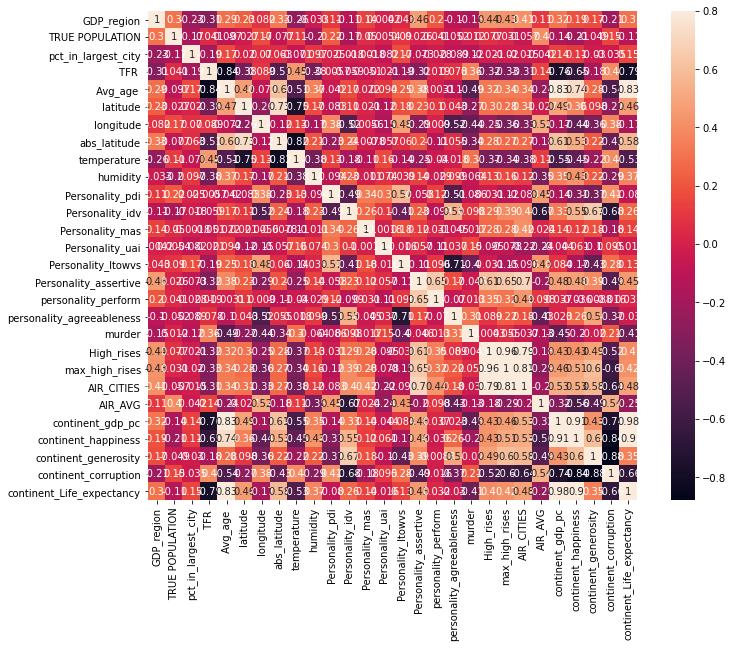

In [23]:
import seaborn as sns
plt.figure(figsize=(30,30))
corr = X_train.corr()
fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8,annot=True, square=True)

In [24]:
to_use = ['GDP_region', 'max_high_rises', 'pct_in_largest_city', 'TRUE POPULATION', 'latitude', 
          'personality_perform', 'Personality_idv', 'Personality_ltowvs', 'AIR_AVG', 
          'Personality_mas', 'Personality_pdi', 'continent_Life_expectancy', 'personality_agreeableness', 
          'Personality_uai', 'continent_happiness', 'continent_corruption', 'continent_generosity',
           'longitude', 'murder', 'humidity', ' TFR ',
           'temperature', 'Personality_assertive']

In [25]:
test = pd.read_csv(f"/kaggle/input/covid19-global-forecasting-week-{week}/test.csv")
test['Date'] = pd.to_datetime(test['Date'])
test_first_date = test['Date'].values[0]
test_last_date = test['Date'].values[-1]
print(f'Test period from {str(test_first_date)[:10]} to {str(test_last_date)[:10]}')

Test period from 2020-04-02 to 2020-05-14


In [26]:
period = (np.array(test_last_date, dtype='datetime64[D]').astype(np.int64) - np.array(train_last_date, dtype='datetime64[D]').astype(np.int64))

In [27]:
print(f"Prediction days: {(np.array(test_last_date, dtype='datetime64[D]').astype(np.int64) - np.array(train_last_date, dtype='datetime64[D]').astype(np.int64))+1}")
print(f"Public set: {(np.array(train_last_date, dtype='datetime64[D]').astype(np.int64) - np.array(test_first_date, dtype='datetime64[D]').astype(np.int64))+1}")
print(f"Full prediction set: {(np.array(test_last_date, dtype='datetime64[D]').astype(np.int64) - np.array(test_first_date, dtype='datetime64[D]').astype(np.int64))+1}")

Prediction days: 34
Public set: 10
Full prediction set: 43


Data window for forecast:

In [28]:
win = 20

In [29]:
base_1 = train.pivot(index='Date', columns="geo", values='ConfirmedCases').iloc[-win,:].values
base_2 = train.pivot(index='Date', columns="geo", values='Fatalities').iloc[-win,:].values

In [30]:
train.pivot(index='geo', columns="Date", values=['ConfirmedCases']).values

array([[   0.,    0.,    0., ...,  484.,  521.,  555.],
       [   0.,    0.,    0., ...,  409.,  416.,  433.],
       [   0.,    0.,    0., ..., 1666., 1761., 1825.],
       ...,
       [   0.,    0.,    0., ...,    4.,    4.,    4.],
       [   0.,    0.,    0., ...,   39.,   40.,   40.],
       [   0.,    0.,    0., ...,   11.,   13.,   14.]])

In [31]:
train

Id Province_State Country_Region       Date  ConfirmedCases  \
30        31            NaN    Afghanistan 2020-02-21             0.0   
31        32            NaN    Afghanistan 2020-02-22             0.0   
32        33            NaN    Afghanistan 2020-02-23             0.0   
33        34            NaN    Afghanistan 2020-02-24             1.0   
34        35            NaN    Afghanistan 2020-02-25             1.0   
...      ...            ...            ...        ...             ...   
25348  35645            NaN       Zimbabwe 2020-04-07            11.0   
25349  35646            NaN       Zimbabwe 2020-04-08            11.0   
25350  35647            NaN       Zimbabwe 2020-04-09            11.0   
25351  35648            NaN       Zimbabwe 2020-04-10            13.0   
25352  35649            NaN       Zimbabwe 2020-04-11            14.0   

       Fatalities          geo  
30            0.0  Afghanistan  
31            0.0  Afghanistan  
32            0.0  Afghanistan  
33            0.0  Afghanistan  
34            0.0  Afghanistan  
...           ...          ...  
25348         2.0     Zimbabwe  
25349         3.0     Zimbabwe  
25350         3.0     Zimbabwe  
25351         3.0     Zimbabwe  
25352         3.0     Zimbabwe  

[15963 rows x 7 columns]

I use only new cases and new death's dynamics to make the prediction.

In [32]:
train['ConfirmedCases'] = train['ConfirmedCases'] - train.groupby('geo')['ConfirmedCases'].shift(periods=1)
train['Fatalities'] = train['Fatalities'] - train.groupby('geo')['Fatalities'].shift(periods=1)

train = train.groupby('geo').tail(train.groupby('geo').size().values[0]-1)

train['ConfirmedCases'] = np.where(train['ConfirmedCases'] < 0, 0.0, train['ConfirmedCases'])
train['Fatalities'] = np.where(train['Fatalities'] < 0, 0.0, train['Fatalities'])
train

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


Id Province_State Country_Region       Date  ConfirmedCases  \
31        32            NaN    Afghanistan 2020-02-22             0.0   
32        33            NaN    Afghanistan 2020-02-23             0.0   
33        34            NaN    Afghanistan 2020-02-24             1.0   
34        35            NaN    Afghanistan 2020-02-25             0.0   
35        36            NaN    Afghanistan 2020-02-26             0.0   
...      ...            ...            ...        ...             ...   
25348  35645            NaN       Zimbabwe 2020-04-07             1.0   
25349  35646            NaN       Zimbabwe 2020-04-08             0.0   
25350  35647            NaN       Zimbabwe 2020-04-09             0.0   
25351  35648            NaN       Zimbabwe 2020-04-10             2.0   
25352  35649            NaN       Zimbabwe 2020-04-11             1.0   

       Fatalities          geo  
31            0.0  Afghanistan  
32            0.0  Afghanistan  
33            0.0  Afghanistan  
34            0.0  Afghanistan  
35            0.0  Afghanistan  
...           ...          ...  
25348         1.0     Zimbabwe  
25349         1.0     Zimbabwe  
25350         0.0     Zimbabwe  
25351         0.0     Zimbabwe  
25352         0.0     Zimbabwe  

[15650 rows x 7 columns]

Select only March and April:

In [33]:
train_add['geo']

0        Afghanistan
1        Afghanistan
2        Afghanistan
3        Afghanistan
4        Afghanistan
            ...     
15958       Zimbabwe
15959       Zimbabwe
15960       Zimbabwe
15961       Zimbabwe
15962       Zimbabwe
Name: geo, Length: 15963, dtype: object

In [36]:
X_train['geo'] = train_add['geo']

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [37]:
X_train.describe(include='all')

GDP_region  TRUE POPULATION  pct_in_largest_city          TFR   \
count   15963.000000     1.596300e+04         15963.000000  15963.000000   
unique           NaN              NaN                  NaN           NaN   
top              NaN              NaN                  NaN           NaN   
freq             NaN              NaN                  NaN           NaN   
mean        4.094444     2.459289e+07            15.865065      2.247273   
std         1.928112     8.464646e+07            13.628797      1.025212   
min         0.000000     8.010000e+02             0.453000      1.100000   
25%         2.500000     1.326535e+06             7.492000      1.700000   
50%         4.100000     6.378000e+06            15.865065      1.800000   
75%         5.700000     2.459289e+07            20.000000      2.300000   
max         8.500000     1.380004e+09           109.632000      7.000000   

            Avg_age      latitude     longitude  abs_latitude   temperature  \
count   15963.000000  15963.00000  15963.000000  15963.000000  15963.000000   
unique           NaN          NaN           NaN           NaN           NaN   
top              NaN          NaN           NaN           NaN           NaN   
freq             NaN          NaN           NaN           NaN           NaN   
mean       34.221639     25.02549      4.487680     30.292810     16.646939   
std         7.993698     23.03956     78.090077     15.682498     12.202686   
min        15.000000    -41.45000   -157.500000      0.020000    -35.200000   
25%        29.000000     12.87000    -70.040000     17.610000      7.900000   
50%        38.000000     30.38000      9.000000     31.790000     16.646939   
75%        38.000000     41.90000     54.000000     41.900000     26.500000   
max        58.000000     71.71000    178.070000     71.710000     40.800000   

            humidity  Personality_pdi  Personality_idv  Personality_mas  \
count   15963.000000     15963.000000     15963.000000     15963.000000   
unique           NaN              NaN              NaN              NaN   
top              NaN              NaN              NaN              NaN   
freq             NaN              NaN              NaN              NaN   
mean       69.394218        52.154831        57.581449        53.005652   
std        16.710368        18.381609        26.208547        15.189720   
min        10.600000         0.000000         0.000000         0.000000   
25%        65.500000        40.000000        41.000000        53.005652   
50%        74.800000        52.154831        57.581449        53.005652   
75%        80.000000        60.000000        80.000000        62.000000   
max        96.300000       104.000000        91.000000       110.000000   

        Personality_uai  Personality_ltowvs  Personality_assertive  \
count      15963.000000        15963.000000           15963.000000   
unique              NaN                 NaN                    NaN   
top                 NaN                 NaN                    NaN   
freq                NaN                 NaN                    NaN   
mean          50.381643           45.380364               3.587255   
std           19.216115           21.782054               0.638638   
min            0.000000            0.000000               3.000000   
25%           46.000000           26.000000               3.000000   
50%           50.381643           45.380364               3.410000   
75%           50.381643           52.000000               4.390000   
max          112.000000          100.000000               4.720000   

        personality_perform  personality_agreeableness        murder  \
count          15963.000000               15963.000000  15963.000000   
unique                  NaN                        NaN           NaN   
top                     NaN                        NaN           NaN   
freq                    NaN                        NaN           NaN   
mean               3.234322                  4

In [38]:

X = X_train.set_index('geo')
X.loc[~X.index.duplicated(keep='first')]
add_d = X.loc[~X.index.duplicated(keep='first')][to_use]

In [39]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
add_d = scaler.fit_transform(add_d)

In [40]:
train_cases = train.pivot(index='Date', columns="geo", values='ConfirmedCases').iloc[:-3,:].values
valid_cases = train.pivot(index='Date', columns="geo", values='ConfirmedCases').iloc[-(win+3):,:].values

train_fatal = train.pivot(index='Date', columns="geo", values='Fatalities').iloc[:-3,:].values
valid_fatal = train.pivot(index='Date', columns="geo", values='Fatalities').iloc[-(win+3):,:].values

In [41]:
train_cases.shape

(47, 313)

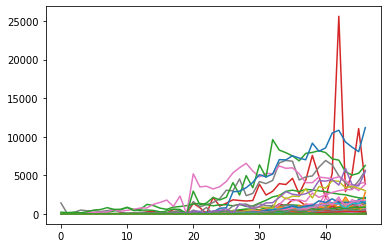

In [42]:
_ = plt.plot(train_cases)

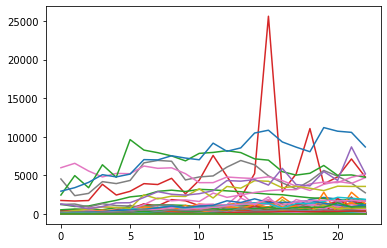

In [43]:
_ = plt.plot(valid_cases)

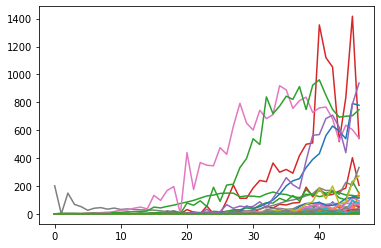

In [44]:
_ = plt.plot(train_fatal)

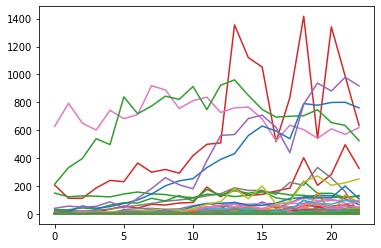

In [45]:
_ = plt.plot(valid_fatal)

## Model

We need to install pytorch lightning library:

In [46]:
%%bash

pip install pytorch_lightning

In [47]:
import torch.nn as nn
import torch
import torch.nn.functional as F
import pytorch_lightning as ptl

from torch import optim
from torch.utils.data import DataLoader
from collections import OrderedDict

Loss function:

Data loader:

## New confirmed cases prediction

In [53]:
#rom p.loggers import TensorBoardLogger
#logger = ptl.loggers.TensorBoardLogger("tb_logs", name="model_bis")
model_cases = DSANet(train_cases, valid_cases,add_d,add_d, train_cases.shape[1], window=win, learning_rate=0.005, horizon=1, drop_prob=0.2)

trainer = ptl.Trainer(val_check_interval=1, max_steps=200,gpus=1)#,logger=logger) 
trainer.fit(model_cases) 

/opt/conda/lib/python3.6/site-packages/pytorch_lightning/utilities/warnings.py:18: RuntimeWarning: Displayed epoch numbers in the progress bar start from "1" until v0.6.x, but will start from "0" in v0.8.0.
  warnings.warn(*args, **kwargs)


1

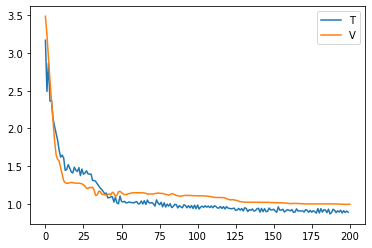

In [54]:
plt.plot(model_cases.losses_t,label = 'T')
plt.plot(model_cases.losses_v,label='V')
plt.legend()

In [ ]:
from glob import glob

sd = torch.load(glob("/kaggle/working/lightning_logs/version_8/checkpoints/*.ckpt")[0])
model_cases.load_state_dict(sd['state_dict'])

In [59]:
input = train.pivot(index='Date', columns="geo", values='ConfirmedCases').iloc[-win:,:].values

for i in range(period):
    ins = torch.tensor(input[-win:, :]).cuda()
    add_cuda = torch.tensor([add_d]).cuda()
    pred = model_cases(ins.unsqueeze(dim=0).float(),add_cuda.float())
    
    input = np.concatenate([input, np.array(pred.detach().cpu().numpy(), dtype=np.int).reshape(1, train_cases.shape[1])], axis=0)

## New fatal cases prediction

In [61]:
model_fatal = DSANet(train_fatal, valid_fatal, add_d,add_d, train_fatal.shape[1], window=win, learning_rate=0.0005, horizon=1, drop_prob=0.2)

trainer = ptl.Trainer(val_check_interval=1, max_steps=200,gpus=1) #
trainer.fit(model_fatal) 

1

In [ ]:
sd = torch.load(glob("/kaggle/working/lightning_logs/version_11/checkpoints/*.ckpt")[0])
model_fatal.load_state_dict(sd['state_dict'])

In [63]:
input2 = train.pivot(index='Date', columns="geo", values='Fatalities').iloc[-win:,:].values

for i in range(period):
    
    ins = torch.tensor(input2[-win:, :]).cuda()
    add_cuda = torch.tensor([add_d]).cuda()
    pred = model_fatal(ins.unsqueeze(dim=0).float(),add_cuda.float())
    
    input2 = np.concatenate([input2, np.array(pred.detach().cpu().numpy(), dtype=np.int).reshape(1, train_fatal.shape[1])], axis=0)

## Forecast preparation

In [64]:
pred_size = (np.array(test_last_date, dtype='datetime64[D]').astype(np.int64) - np.array(test_first_date, dtype='datetime64[D]').astype(np.int64))+1

In [65]:
pd.DataFrame(np.array(input.cumsum(0) + base_1, dtype=np.int)[-pred_size:,:], columns=train.pivot(index='Date', columns="geo", values='ConfirmedCases').columns).loc[:, ['US_New York', 'Ukraine', 'Italy', 'Spain']]

geo  US_New York  Ukraine   Italy   Spain
0          97590      897  120031  118433
1         108071     1072  124616  125567
2         118917     1225  129421  132536
3         128244     1308  133737  138014
4         136899     1319  137336  143043
5         144959     1462  140375  148310
6         156145     1668  144211  154588
7         166863     1892  148415  159590
8         177432     2203  152366  164641
9         186110     2511  157060  169395
10        197231     2724  161736  176357
11        209220     2918  166311  183607
12        221995     3181  170960  190654
13        235307     3461  176016  197585
14        248670     3686  181071  204021
15        261532     3939  185745  210291
16        274516     4214  190651  216917
17        288810     4493  195837  224086
18        303884     4803  201125  231351
19        318740     5180  206644  238296
20        334153     5562  212609  245789
21        349970     5903  218755  253783
22        366553     6258  224867  262333
23        383858     6642  231331  271251
24        402428     7029  238121  280555
25        421426     7419  245040  289743
26        440380     7835  252031  298867
27        459949     8260  259298  308483
28        480434     8679  266806  318573
29        501767     9135  274446  328963
30        523675     9636  282479  339532
31        546399    10149  290915  350516
32        569801    10662  299592  361922
33        593801    11195  308491  373759
34        618901    11747  317768  386261
35        645171    12306  327417  399243
36        672341    12891  337312  412495
37        700157    13505  347550  426014
38        728904    14130  358165  440040
39        758689    14766  369083  454608
40        789447    15435  380321  469634
41        821365    16139  392016  485208
42        854449    16863  404179  501305

In [66]:
pd.DataFrame(np.array(input2.cumsum(0) + base_2, dtype=np.int)[-pred_size:,:], columns=train.pivot(index='Date', columns="geo", values='ConfirmedCases').columns).loc[:, ['US_New York', 'Ukraine', 'Italy', 'Spain']]

geo  US_New York  Ukraine  Italy  Spain
0           2414       22  14516  10887
1           2976       27  15282  11737
2           3606       32  15963  12486
3           4200       37  16488  13180
4           4739       38  17124  13880
5           5530       45  17728  14584
6           6309       52  18270  15331
7           7108       57  18880  15986
8           7908       69  19450  16620
9           8668       73  20069  17145
10          9184       77  20506  17655
11          9685       80  20978  18096
12         10115       83  21459  18557
13         10512       85  21928  19002
14         10887       87  22446  19507
15         11242       90  22987  19998
16         11565       93  23494  20464
17         11830       96  24005  20968
18         12025       97  24545  21439
19         12218       98  25050  21937
20         12385       99  25518  22444
21         12539       99  25998  22926
22         12740      100  26481  23418
23         12989      101  26948  23928
24         13233      101  27418  24452
25         13574      104  27874  24974
26         13944      107  28332  25496
27         14317      109  28781  25981
28         14696      112  29188  26460
29         15085      113  29596  26899
30         15444      115  29945  27311
31         15831      117  30299  27708
32         16213      118  30664  28103
33         16608      120  31015  28482
34         17006      122  31360  28867
35         17378      124  31714  29224
36         17721      126  32058  29557
37         18029      127  32388  29890
38         18275      127  32712  30200
39         18501      127  33022  30503
40         18709      127  33329  30808
41         18889      127  33647  31109
42         19070      127  33963  31422

Convert predicted new cases to total cases:

In [67]:
input = input.cumsum(0) + base_1
input2 = input2.cumsum(0) + base_2

In [68]:
import datetime 

def prov(i):
    try:
        return i.split("_")[1]
    except:
        return None

res = pd.DataFrame(input2[-pred_size:,:], columns=train.pivot(index='Date', columns="geo", values='Fatalities').columns).unstack().reset_index(name='Fatalities') \
    .merge(
    pd.DataFrame(input[-pred_size:,:], columns=train.pivot(index='Date', columns="geo", values='ConfirmedCases').columns).unstack().reset_index(name='ConfirmedCases'),
          how='left', on=['geo', 'level_1']
)

res['Date'] = [test.Date[0] + datetime.timedelta(days=i) for i in res['level_1']]
res['Province_State'] = [prov(i) for i in res['geo']]
res['Country_Region'] = [i.split("_")[0] for i in res['geo']]

res

geo  level_1  Fatalities  ConfirmedCases       Date  \
0      Afghanistan        0         6.0           273.0 2020-04-02   
1      Afghanistan        1         6.0           281.0 2020-04-03   
2      Afghanistan        2         7.0           299.0 2020-04-04   
3      Afghanistan        3         7.0           349.0 2020-04-05   
4      Afghanistan        4        11.0           367.0 2020-04-06   
...            ...      ...         ...             ...        ...   
13454     Zimbabwe       38         4.0            19.0 2020-05-10   
13455     Zimbabwe       39         4.0            19.0 2020-05-11   
13456     Zimbabwe       40         4.0            19.0 2020-05-12   
13457     Zimbabwe       41         4.0            19.0 2020-05-13   
13458     Zimbabwe       42         4.0            19.0 2020-05-14   

      Province_State Country_Region  
0               None    Afghanistan  
1               None    Afghanistan  
2               None    Afghanistan  
3               None    Afghanistan  
4               None    Afghanistan  
...              ...            ...  
13454           None       Zimbabwe  
13455           None       Zimbabwe  
13456           None       Zimbabwe  
13457           None       Zimbabwe  
13458           None       Zimbabwe  

[13459 rows x 7 columns]

Adjust results and create submission:

In [69]:
sub = pd.read_csv(f"/kaggle/input/covid19-global-forecasting-week-{week}/submission.csv")

sub = test.merge(res, how='left', on=['Date', 'Province_State', 'Country_Region']).loc[:, ["ForecastId", "ConfirmedCases", "Fatalities"]]
sub['Fatalities'] = np.where(sub['Fatalities']*7 > sub["ConfirmedCases"], sub["ConfirmedCases"] / 7, sub['Fatalities']) 
sub["ConfirmedCases"] = np.where(((sub['Fatalities'] / sub["ConfirmedCases"]) < 0.0005) & (sub["ConfirmedCases"] > 1000), sub['Fatalities']*2000, sub["ConfirmedCases"])

sub['Fatalities'] = np.array(sub['Fatalities'], dtype=np.int)
sub["ConfirmedCases"] = np.array(sub["ConfirmedCases"], dtype=np.int)

sub

ForecastId  ConfirmedCases  Fatalities
0               1             273           6
1               2             281           6
2               3             299           7
3               4             349           7
4               5             367          11
...           ...             ...         ...
13454       13455              19           2
13455       13456              19           2
13456       13457              19           2
13457       13458              19           2
13458       13459              19           2

[13459 rows x 3 columns]

Write prediction:

In [70]:
sub.to_csv("submission.csv", index=False)